# Question 1

## (a)

In [1]:
stan_code = """
functions {
  real linear_hazard_lpdf(real t, real alpha, real beta) {
    return log(alpha + beta * t) - alpha * t - 0.5 * beta * t^2;
  }
}

data {
  int<lower=0> n;              // number of observations
  array[n] real<lower=0> t;    // observed data
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
}

model {
  alpha ~ gamma(0.1, 0.1);
  beta ~ gamma(0.2, 0.1);
  for (i in 1:n) {
    t[i] ~ linear_hazard(alpha, beta);
  }
}
"""

## (b)

### i.

In [2]:
import stan
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load observed data
t = np.loadtxt('./linear_hazard_event_times.txt')

# Data dictionary for Stan
sm_data = {'n': len(t), 't': t}

# Build Stan object for model
sm = stan.build(stan_code, sm_data, random_seed=1)

# Set number of MCMC chains and iterations, then sample
chains, samples, burn = 1, 10000, 10000
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_ilfc2m6o/model_spdxig6v.stan', line 19, column 16: There
    is a gamma or inverse-gamma distribution with parameters that are equal
    to each other and set to values less than 1. This is mathematically
    acceptable and can make sense in some problems, but typically we see this
    model used as an attempt to assign a noninformative prior distribution.
    In fact, priors such as inverse-gamma(.001,.001) can be very strong, as
    explained by Gelman (2006). Instead we recommend something like a
    normal(0,1) or student_t(4,0,1), with parameter constrained to be
    positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


In [4]:
def plot_samples(fit, par, name):
    '''Function to plot trace plots of the sampled values.'''
    plt.figure()
    plt.title(f'Trace plot of sampled values of {name}')
    plt.xlabel('Iteration')
    plt.ylabel(name)
    par_mx = fit[par].reshape(samples, chains)
    for i in range(chains):
        x = i * samples + np.arange(samples)
        plt.plot(x, par_mx[:, i])
    plt.show()

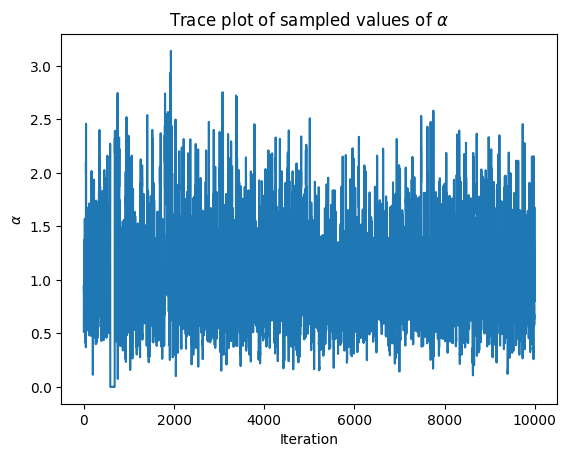

In [5]:
plot_samples(fit, 'alpha', r'$\alpha$')

The chain explores values of $\alpha$ between $0$ approximately $3$ and only appears to get stuck once.

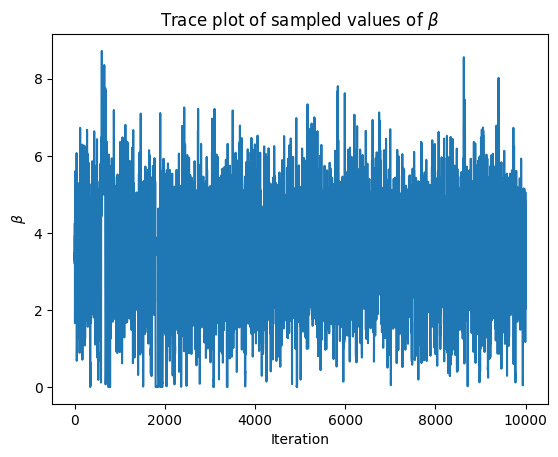

In [6]:
plot_samples(fit, 'beta', r'$\beta$')

The chain explores values of $\beta$ between $0$ approximately $9$ and does not appear to get stuck.

### ii.

Assuming an additive absolute value loss function, the Bayesian posterior estimates of $(\hat{\alpha}$ and $\hat{\beta})$ will be the medians of the sampled values of $\alpha$ and $\beta$, respectively.

In [7]:
# Extract samples
samples_alpha = fit['alpha']
samples_beta = fit['beta']

# Calculate medians, then print
median_alpha = np.median(samples_alpha)
median_beta = np.median(samples_beta)
print(f'Posterior estimate: ({median_alpha}, {median_beta})')

Posterior estimate: (0.9791136631778685, 3.3370078586241148)


### iii.

We must update the Stan code.

In [8]:
stan_code_updated = """
functions {
  real linear_hazard_lpdf(real t, real alpha, real beta) {
    return log(alpha + beta * t) - alpha * t - 0.5 * beta * t^2;
  }
  real linear_hazard_rng(real alpha, real beta) {
    return sqrt((alpha / beta)^2 + exponential_rng(beta / 2)) - alpha / beta;
  }
}

data {
  int<lower=0> n;              // number of observations
  array[n] real<lower=0> t;    // observed data
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
}

model {
  alpha ~ gamma(0.1, 0.1);
  beta ~ gamma(0.2, 0.1);
  for (i in 1:n) {
    t[i] ~ linear_hazard(alpha, beta);
  }
}

generated quantities {
  array[n] real<lower=0> t_rep;
  real log_lhd = 0;
  real log_lhd_rep = 0;
  real ppp;
  for (i in 1:n) {
    log_lhd += linear_hazard_lpdf(t[i] | alpha, beta);
    t_rep[i] = linear_hazard_rng(alpha, beta);
    log_lhd_rep += linear_hazard_lpdf(t_rep[i] | alpha, beta);
  }
  ppp = log_lhd >= log_lhd_rep ? 1 : 0;
}
"""

In [9]:
# Build Stan object for model, then sample
sm = stan.build(stan_code_updated, sm_data, random_seed=1)
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

# Calculate posterior predictive p-value, then print
samples_ppp = fit['ppp']
mean_ppp = np.mean(samples_ppp)
print(f'Posterior predictive p-value: {mean_ppp}')

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_kyg8w93z/model_7muzjch6.stan', line 22, column 16: There
    is a gamma or inverse-gamma distribution with parameters that are equal
    to each other and set to values less than 1. This is mathematically
    acceptable and can make sense in some problems, but typically we see this
    model used as an attempt to assign a noninformative prior distribution.
    In fact, priors such as inverse-gamma(.001,.001) can be very strong, as
    explained by Gelman (2006). Instead we recommend something like a
    normal(0,1) or student_t(4,0,1), with parameter constrained to be
    positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!


Posterior predictive p-value: 0.4703


The $p$-value suggests no statistical significance, suggesting a good model fit.

# Question 2

## (a)

### i.

We have that

$$
\pi ( \theta_j \mid \theta _ {-j} ) = h_j (\theta_j) g_j ( \theta _{-j} ) \exp \{ \eta_j ( \theta _{-j} ) ^T \cdot T_j (\theta_j) \}.
$$

Taking the natural logarithm of both sides,

$$
\log \pi ( \theta_j \mid \theta _ {-j} ) = \log \left[ h_j (\theta_j) g_j ( \theta _{-j} ) \exp \{ \eta_j ( \theta _{-j} ) ^T \cdot T_j (\theta_j) \} \right]
$$

$$
\implies \log \pi ( \theta_j \mid \theta _ {-j} ) = \log h_j (\theta_j) + \log g_j ( \theta _{-j} ) + \log \exp \{ \eta_j ( \theta _{-j} ) ^T \cdot T_j (\theta_j) \}
$$

$$
\implies \log \pi ( \theta_j \mid \theta _ {-j} ) = \log h_j (\theta_j) + \log g_j ( \theta _{-j} ) + \eta_j ( \theta _{-j} ) ^T \cdot T_j (\theta_j).
$$

Taking the expectation with respect to $q_{-j}$,

$$
\mathbb{E}_{q_{-j}} \log \pi(\theta_j \mid \theta_{-j}) = \mathbb{E}_{q_{-j}} \left[ \log h_j (\theta_j) + \log g_j ( \theta _{-j} ) + \eta_j ( \theta _{-j} ) ^T \cdot T_j (\theta_j) \right]
$$

$$
\implies \mathbb{E}_{q_{-j}} \log \pi(\theta_j \mid \theta_{-j}) = \mathbb{E}_{q_{-j}} \log h_j (\theta_j) + \mathbb{E}_{q_{-j}} \log g_j ( \theta _{-j} ) + \mathbb{E}_{q_{-j}} \left[ \eta_j ( \theta _{-j} ) ^T \cdot T_j (\theta_j) \right].
$$

Since $\log h_j(\theta_j)$, $T_j(\theta_j)$ are constant with respect to $\theta_{-j}$,

$$
\mathbb{E}_{q_{-j}} \log \pi(\theta_j \mid \theta_{-j}) = \log h_j(\theta_j) + \mathbb{E}_{q_{-j}} \log g_j(\theta_{-j}) + \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j).
$$

$$
q_j ( \theta_j ) \propto \exp \{ \mathbb{E}_{q_{-j}} \log \pi(\theta_j \mid \theta_{-j}) \}
$$

$$
= \exp \left\{ \log h_j(\theta_j) + \mathbb{E}_{q_{-j}} \log g_j(\theta_{-j}) + \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j) \right\}
$$

$$
= \exp \{ \log h_j(\theta_j) \} \exp \{ \mathbb{E}_{q_{-j}} \log g_j(\theta_{-j}) \} \exp \{ \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j) \}
$$

$$
= h_j(\theta_j) \exp \{ \mathbb{E}_{q_{-j}} \log g_j(\theta_{-j}) \} \exp \{ \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j) \}
$$

Since $\exp \{ \mathbb{E}_{q_{-j}} \log g_j(\theta_{-j}) \}$ is constant with respect to $\theta_j$,

$$
q_j ( \theta_j ) \propto h_j(\theta_j) \exp \{ \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j) \}.
$$

For completeness,

$$
q_j ( \theta_j ) = \frac { h_j(\theta_j) \exp \{ \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j) \} } {\int_{\Theta_j} h_j(\theta_j) \exp \{ \mathbb{E}_{q_{-j}} \left\{ \eta_j ( \theta _{-j} ) \right\} ^T \cdot T_j (\theta_j) \} d\theta_j}.
$$

### ii.

This density belongs to an exponential family. Indeed, it belongs to the same exponential family as $\pi ( \theta_j \mid \theta _ {-j} )$ due to the shared sufficient statistic and base measure.

## (b)

### i.

**Step 1: Start from what we know**

$$
\theta_1 \mid \lambda \sim \text{Normal}(0, \lambda^{-1})
$$

$$
\implies \pi (\theta_1 \mid \lambda) = \frac{\lambda^{1/2}}{(2\pi)^{1/2}} \exp \left\{ -\frac{1}{2} \lambda \theta_1^2 \right\}
$$

$$
\theta_2 \mid \theta_1, \lambda \sim \text{Normal}(\theta_1, \lambda^{-1})
$$

$$
\implies \pi (\theta_2 \mid \theta_1, \lambda) = \frac{\lambda^{1/2}}{(2\pi)^{1/2}} \exp \left\{ -\frac{1}{2} \lambda (\theta_2 - \theta_1)^2 \right\}
= \frac{\lambda^{1/2}}{(2\pi)^{1/2}} \exp \left\{ -\frac{1}{2} \lambda (\theta_1^2 + \theta_2^2 -2 \theta_1 \theta_2) \right\}
$$

$$
\theta_3 \mid \theta_1, \theta_2, \lambda \sim \text{Normal}(\theta_2, \lambda^{-1})
$$

$$
\implies \pi (\theta_3 \mid \theta_1, \theta_2, \lambda) = \frac{\lambda^{1/2}}{(2\pi)^{1/2}} \exp \left\{ -\frac{1}{2} \lambda (\theta_3 - \theta_2)^2 \right\}
= \frac{\lambda^{1/2}}{(2\pi)^{1/2}} \exp \left\{ -\frac{1}{2} \lambda (\theta_2^2 + \theta_3^2 -2 \theta_2 \theta_3) \right\}
$$

These can be combined to obtain $\pi (\theta \mid \lambda)$.

$$
\pi (\theta \mid \lambda) = \pi (\theta_1 \mid \lambda) \, \pi (\theta_2 \mid \theta_1, \lambda) \, \pi (\theta_3 \mid \theta_1, \theta_2, \lambda)
$$

$$
\implies \pi (\theta \mid \lambda) = \frac{\lambda^{3/2}}{(2\pi)^{3/2}} \exp \left\{ - \frac {1}{2} \lambda \left( \theta_1^2 + \theta_1^2 + \theta_2^2 - 2 \theta_1 \theta_2 + \theta_2^2 + \theta_3^2 - 2 \theta_2 \theta_3 \right) \right\}
$$

$$
\implies \pi (\theta \mid \lambda) = \frac{\lambda^{3/2}}{(2\pi)^{3/2}} \exp \left\{ - \frac {1}{2} \lambda \left( 2 \theta_1^2 + 2 \theta_2^2 + \theta_3^2 - 2 \theta_1 \theta_2 - 2 \theta_2 \theta_3 \right) \right\}
$$

**Step 2: Start from the result**

$$
\theta \mid \lambda \sim \text{Normal}_3 \left( \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix}, \lambda^{-1} \begin{pmatrix}
1 & 1 & 1 \\
1 & 2 & 2 \\
1 & 2 & 3
\end{pmatrix} \right)
$$

This means that

$$
\pi ( \theta \mid \lambda ) = \frac{1}{(2\pi)^{3/2} |\Sigma|^{1/2}} \exp \left\{ -\frac{1}{2} (\theta - \mu)^T \Sigma^{-1} (\theta - \mu) \right\}
$$

where

$$
\mu = \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix}, \quad \Sigma = \lambda^{-1} \begin{pmatrix}
1 & 1 & 1 \\
1 & 2 & 2 \\
1 & 2 & 3
\end{pmatrix}.
$$

We have that

$$
|\Sigma| = \lambda^{-3}, \quad \Sigma ^ {-1} = \lambda \begin{pmatrix}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 1
\end{pmatrix}.
$$

Therefore,

$$
\pi ( \theta \mid \lambda ) = \frac{\lambda^{3/2}}{(2\pi)^{3/2}} \exp \left\{ -\frac{1}{2} \begin{pmatrix}
\theta_1 & \theta_2 & \theta_3
\end{pmatrix} \lambda \begin{pmatrix}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 1
\end{pmatrix} \begin{pmatrix}
\theta_1 \\
\theta_2 \\
\theta_3
\end{pmatrix} \right\}
$$

$$
\implies \pi ( \theta \mid \lambda ) = \frac{\lambda^{3/2}}{(2\pi)^{3/2}} \exp \left\{ -\frac{1}{2} \lambda \left( 2 \theta_1^2 + 2 \theta_2^2 + \theta_3^2 - 2 \theta_1 \theta_2 - 2 \theta_2 \theta_3 \right) \right\}.
$$

**Conclude**

Starting from what we know leads to the same $\pi (\theta \mid \lambda)$ as starting from the result. We can therefore conclude that

$$
\theta \mid \lambda \sim \text{Normal}_3 \left( \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix}, \lambda^{-1} \begin{pmatrix}
1 & 1 & 1 \\
1 & 2 & 2 \\
1 & 2 & 3
\end{pmatrix} \right)
$$

as required.

### ii.

Begin by stating the relevant standard result for conditional distributions of a multivariate normal.

Suppose $x \sim \text{Normal}_3(\mu, \Sigma)$. Consider partitioning $x$, $\mu$ and $\Sigma$ as

$$
x = \begin{pmatrix}
x_1 \\
x_2
\end{pmatrix} \quad \text{with sizes} \quad \begin{pmatrix}
1 \times 1 \\
2 \times 1
\end{pmatrix},
$$

$$
\mu = \begin{pmatrix}
\mu_1 \\
\mu_2
\end{pmatrix} \quad \text{with sizes} \quad \begin{pmatrix}
1 \times 1 \\
2 \times 1
\end{pmatrix},
$$

$$
\Sigma = \begin{pmatrix}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{pmatrix} \quad \text{with sizes} \quad \begin{pmatrix}
1 \times 1 & 1 \times 2 \\
2 \times 1 & 2 \times 2
\end{pmatrix}.
$$

Then $x_1 \mid x_2 \sim \text{Normal} (\bar{\mu}, \bar{\Sigma})$ where

$$
\bar{\mu} = \mu_1 + \Sigma_{12} \Sigma_{22}^{-1} (x_2 - \mu_2) \quad \text{and} \quad \bar{\Sigma} = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}.
$$

**Solution for j=1**

We have that $\theta = (\theta_1, \theta_2, \theta_3)$ and $\theta \mid \lambda \sim \text{Normal}_3 (\mu, \Sigma)$ where

$$
\mu = \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix} \quad \text{and} \quad \Sigma = \lambda^{-1} \begin{pmatrix}
1 & 1 & 1 \\
1 & 2 & 2 \\
1 & 2 & 3
\end{pmatrix}.
$$

Therefore, $\theta_1 \mid \theta_2, \theta_3, \lambda \sim \text{Normal} (\bar{\mu}, \bar{\Sigma})$ where

$$
\bar{\mu} = \lambda ^ {-1} \begin{pmatrix}
1 & 1
\end{pmatrix} \lambda \begin{pmatrix}
2 & 2 \\
2 & 3
\end{pmatrix} ^ {-1} \begin{pmatrix}
\theta_2 \\
\theta_3
\end{pmatrix} = \begin{pmatrix}
1 & 1
\end{pmatrix} \begin{pmatrix}
\frac{3}{2} & -1 \\
-1 & 1
\end{pmatrix} \begin{pmatrix}
\theta_2 \\
\theta_3
\end{pmatrix} = \frac {1} {2} \theta_2
$$

and

$$
\bar{\Sigma} = \lambda ^ {-1} \begin{pmatrix}
1
\end{pmatrix} - \lambda ^ {-1} \begin{pmatrix}
1 & 1
\end{pmatrix} \lambda \begin{pmatrix}
2 & 2 \\
2 & 3
\end{pmatrix} ^ {-1} \lambda ^ {-1} \begin{pmatrix}
1 \\
1
\end{pmatrix} = \lambda ^ {-1} - \lambda ^ {-1} \begin{pmatrix}
1 & 1
\end{pmatrix} \begin{pmatrix}
\frac{3}{2} & -1 \\
-1 & 1
\end{pmatrix} \begin{pmatrix}
1 \\
1
\end{pmatrix} = \frac {1} {2} \lambda ^ {-1}.
$$

That is,

$$
\theta_1 \mid \theta_2, \theta_3, \lambda \sim \text{Normal} \left( \frac {\theta_2} {2}, \frac {1} {2 \lambda} \right).
$$

**Solution for j=2**

Let $\theta' = (\theta_2, \theta_1, \theta_3)$. From elementary properties of multivariate normal distributions, $\theta' \mid \lambda \sim \text{Normal}_3 (\mu', \Sigma')$ where

$$
\mu' = \begin{pmatrix}
\mu_2 \\
\mu_1 \\
\mu_3
\end{pmatrix} = \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix}
$$

and

$$
\Sigma' = \begin{pmatrix}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix} \Sigma \begin{pmatrix}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix}^T = \begin{pmatrix}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix} \lambda^{-1} \begin{pmatrix}
1 & 1 & 1 \\
1 & 2 & 2 \\
1 & 2 & 3
\end{pmatrix} \begin{pmatrix}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix} = \lambda^{-1} \begin{pmatrix}
2 & 1 & 2 \\
1 & 1 & 1 \\
2 & 1 & 3
\end{pmatrix}.
$$

Therefore, $\theta_2 \mid \theta_1, \theta_3, \lambda \sim \text{Normal} (\bar{\mu'}, \bar{\Sigma'})$ where

$$
\bar{\mu}' = \lambda ^ {-1} \begin{pmatrix}
1 & 2
\end{pmatrix} \lambda \begin{pmatrix}
1 & 1 \\
1 & 3
\end{pmatrix} ^ {-1} \begin{pmatrix}
\theta_1 \\
\theta_3
\end{pmatrix} = \begin{pmatrix}
1 & 2
\end{pmatrix} \begin{pmatrix}
\frac{3}{2} & -\frac{1}{2} \\
-\frac{1}{2} & \frac{1}{2}
\end{pmatrix} \begin{pmatrix}
\theta_1 \\
\theta_3
\end{pmatrix} = \frac {1} {2} (\theta_1 + \theta_3)
$$

and

$$
\bar{\Sigma}' = \lambda ^ {-1} \begin{pmatrix}
2
\end{pmatrix} - \lambda ^ {-1} \begin{pmatrix}
1 & 2
\end{pmatrix} \lambda \begin{pmatrix}
1 & 1 \\
1 & 3
\end{pmatrix} ^ {-1} \lambda ^ {-1} \begin{pmatrix}
1 \\
2
\end{pmatrix} = 2 \lambda ^ {-1} - \lambda ^ {-1} \begin{pmatrix}
1 & 2
\end{pmatrix} \begin{pmatrix}
\frac{3}{2} & -\frac{1}{2} \\
-\frac{1}{2} & \frac{1}{2}
\end{pmatrix} \begin{pmatrix}
1 \\
2
\end{pmatrix} = \frac {1} {2} \lambda ^ {-1}.
$$

That is,

$$
\theta_2 \mid \theta_1, \theta_3, \lambda \sim \text{Normal} \left( \frac {\theta_1 + \theta_3} {2}, \frac {1} {2 \lambda} \right).
$$

**Solution for j=3**

Let $\theta'' = (\theta_3, \theta_1, \theta_2)$. From elementary properties of multivariate normal distributions, $\theta'' \mid \lambda \sim \text{Normal}_3 (\mu'', \Sigma'')$ where

$$
\mu'' = \begin{pmatrix}
\mu_3 \\
\mu_1 \\
\mu_2
\end{pmatrix} = \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix}
$$

and

$$
\Sigma'' = \begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0
\end{pmatrix} \Sigma \begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0
\end{pmatrix}^T = \begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0
\end{pmatrix} \lambda^{-1} \begin{pmatrix}
1 & 1 & 1 \\
1 & 2 & 2 \\
1 & 2 & 3
\end{pmatrix} \begin{pmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0
\end{pmatrix} = \lambda^{-1} \begin{pmatrix}
3 & 1 & 2 \\
1 & 1 & 1 \\
2 & 1 & 2
\end{pmatrix}.
$$

Therefore, $\theta_3 \mid \theta_1, \theta_2, \lambda \sim \text{Normal} (\bar{\mu}'', \bar{\Sigma}'')$ where

$$
\bar{\mu}'' = \lambda ^ {-1} \begin{pmatrix}
1 & 2
\end{pmatrix} \lambda \begin{pmatrix}
1 & 1 \\
1 & 2
\end{pmatrix} ^ {-1} \begin{pmatrix}
\theta_1 \\
\theta_2
\end{pmatrix} = \begin{pmatrix}
1 & 2
\end{pmatrix} \begin{pmatrix}
2 & -1 \\
-1 & 1
\end{pmatrix} \begin{pmatrix}
\theta_1 \\
\theta_2
\end{pmatrix} = \theta_2
$$

and

$$
\bar{\Sigma}'' = \lambda ^ {-1} \begin{pmatrix}
3
\end{pmatrix} - \lambda ^ {-1} \begin{pmatrix}
1 & 2
\end{pmatrix} \lambda \begin{pmatrix}
1 & 1 \\
1 & 2
\end{pmatrix} ^ {-1} \lambda ^ {-1} \begin{pmatrix}
1 \\
2
\end{pmatrix} = 3 \lambda ^ {-1} - \lambda ^ {-1} \begin{pmatrix}
1 & 2
\end{pmatrix} \begin{pmatrix}
2 & -1 \\
-1 & 1
\end{pmatrix} \begin{pmatrix}
1 \\
2
\end{pmatrix} = \lambda ^ {-1}.
$$

That is,

$$
\theta_3 \mid \theta_1, \theta_2, \lambda \sim \text{Normal} \left( \theta_2, \frac {1} {\lambda} \right).
$$

**Solution for $\lambda \mid \theta$**

We have that

$$
\lambda \sim \text{Gamma} (1, 1)
$$

$$
\implies \pi (\lambda) = \frac{1^1}{\Gamma(1)} \lambda ^ {1 - 1} \exp \{ {-(1)\lambda} \} = \exp \{ {-\lambda} \}.
$$

From 2. (b) i.,

$$
\pi (\theta \mid \lambda) = \frac{\lambda^{3/2}}{(2\pi)^{3/2}} \exp \left\{ - \frac {1}{2} \lambda \left( 2 \theta_1^2 + 2 \theta_2^2 + \theta_3^2 - 2 \theta_1 \theta_2 - 2 \theta_2 \theta_3 \right) \right\}.
$$

By Bayes' theorem,

$$
\pi (\lambda \mid \theta) \propto \pi (\theta \mid \lambda) \pi (\lambda).
$$

Therefore,

$$
\pi (\lambda \mid \theta) \propto \frac{\lambda^{3/2}}{(2\pi)^{3/2}} \exp \left\{ - \frac {1}{2} \lambda \left( 2 \theta_1^2 + 2 \theta_2^2 + \theta_3^2 - 2 \theta_1 \theta_2 - 2 \theta_2 \theta_3 \right) \right\} \exp \{ {-\lambda} \}
$$

$$
\propto \lambda^{5/2 - 1} \exp \left\{ - \left( \theta_1^2 + \theta_2^2 + \frac{1}{2} \theta_3^2 - \theta_1 \theta_2 - \theta_2 \theta_3 + 1 \right) \lambda \right\}.
$$

That is,

$$
\lambda \mid \theta \sim \text{Gamma} \left( \frac{5}{2}, \theta_1^2 + \theta_2^2 + \frac{1}{2} \theta_3^2 - \theta_1 \theta_2 - \theta_2 \theta_3 + 1 \right).
$$

### iii.

$$
q_{\lambda} (\lambda) \propto \exp \{ \mathbb{E}_{\theta} \log \pi (\lambda \mid \theta) \}
$$

Using the expression for $\pi (\lambda \mid \theta)$ obtained in 2. (b). ii,

$$
q_{\lambda} (\lambda) \propto \exp \left\{ \mathbb{E}_{\theta} \left[ \log \lambda^{3/2} \exp \left\{ - \left( \theta_1^2 + \theta_2^2 + \frac{1}{2} \theta_3^2 - \theta_1 \theta_2 - \theta_2 \theta_3 + 1 \right) \lambda \right\} \right] \right\}
$$

$$
= \exp \left\{ \mathbb{E}_{\theta} \left[ \log \lambda^{3/2} + \log \exp \left\{ - \left( \theta_1^2 + \theta_2^2 + \frac{1}{2} \theta_3^2 - \theta_1 \theta_2 - \theta_2 \theta_3 + 1 \right) \lambda \right\} \right] \right\}
$$

$$
= \exp \left\{ \mathbb{E}_{\theta} \left[ \log \lambda^{3/2} - \left( \theta_1^2 + \theta_2^2 + \frac{1}{2} \theta_3^2 - \theta_1 \theta_2 - \theta_2 \theta_3 + 1 \right) \lambda \right] \right\}
$$

$$
= \exp \left\{ \log \lambda^{3/2} - \mathbb{E}_{\theta} \left[ \theta_1^2 + \theta_2^2 + \frac{1}{2} \theta_3^2 - \theta_1 \theta_2 - \theta_2 \theta_3 + 1 \right] \lambda \right\}
$$

$$
= \exp \left\{ \log \lambda^{3/2} - \left( \mathbb{E}_{q_1} \left[ \theta_1^2 \right] + \mathbb{E}_{q_2} \left[ \theta_2^2 \right] + \frac{1}{2} \mathbb{E}_{q_3} \left[ \theta_3^2 \right] - \mathbb{E}_{q_1 q_2} \left[ \theta_1 \theta_2 \right] - \mathbb{E}_{q_2 q_3} \left[ \theta_2 \theta_3 \right] + 1 \right) \lambda \right\}.
$$

Since $\text{var}[\theta_j] = \mathbb{E}_{q_j} [\theta_j^2] - \mathbb{E}_{q_j} [\theta_j]^2$,

$$
q_\lambda (\lambda) \propto \exp \left\{ \log \lambda^{3/2} - \left( 1 + 1 + \frac{1}{2} - 0 - 0 + 1 \right) \lambda \right\}
$$

$$
= \exp \left\{ \log \lambda^{3/2} - \frac{7}{2} \lambda \right\}
$$

$$
= \exp \left\{ \log \lambda^{3/2} \right\} \exp \left\{ - \frac{7}{2} \lambda \right\}
$$

$$
= \lambda^{3/2} \exp \left\{ - \frac{7}{2} \lambda \right\}
$$

$$
= \lambda^{5/2 - 1} \exp \left\{ - \frac{7}{2} \lambda \right\}.
$$

That is,

$$
q_{\lambda} (\lambda) = \text{Gamma} \left( \lambda \mid \frac{5}{2}, \frac{7}{2} \right).
$$

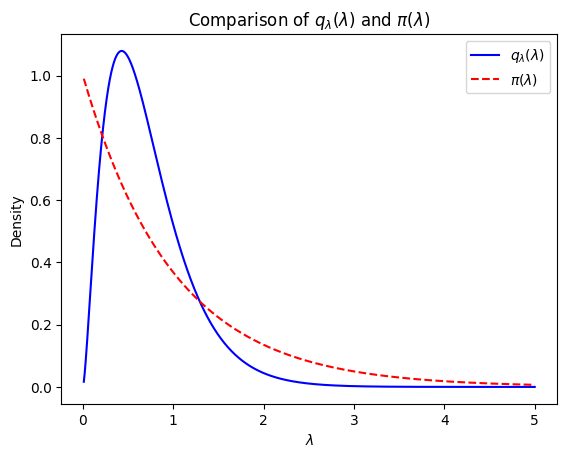

In [10]:
from scipy.stats import gamma

a_q = 5/2
b_q = 7/2
a_pi = 1
b_pi = 1

lambda_values = np.linspace(0.01, 5, 10000)
q_lambda_density = gamma.pdf(lambda_values, a_q, scale=1/b_q)
pi_lambda_density = gamma.pdf(lambda_values, a_pi, scale=1/b_pi)

plt.figure()
plt.plot(lambda_values, q_lambda_density, label=r'$q_\lambda(\lambda)$', color='blue')
plt.plot(lambda_values, pi_lambda_density, label=r'$\pi(\lambda)$', color='red', linestyle='--')
plt.title('Comparison of $q_\lambda(\lambda)$ and $\pi(\lambda)$')
plt.xlabel(r'$\lambda$')
plt.ylabel('Density')
plt.legend()
plt.show()

The peak of $q_\lambda (\lambda)$ is to the right of the peak of $\pi (\lambda)$. This means that the CAVI update equation for the component density for the precision parameter $\lambda$, assuming the given initial mean-field distributions, is: less than the marginal density for small values of $\lambda$ (where $\lambda$ is less than approximately $0.2$); greater than the marginal density for values of $\lambda$ between approximately $0.2$ and $1.3$; and less than the marginal density for large values of $\lambda$ (where $\lambda$ is greater than approximately $1.3$). In the limit as $\lambda$ tends to $+\infty$, both $q_\lambda (\lambda)$ and $\pi (\lambda)$ tend to $0$.